In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# import eli5
from IPython.display import HTML
import json
import matplotlib.pyplot as plt
%matplotlib inline

%env JOBLIB_TEMP_FOLDER=/tmp

env: JOBLIB_TEMP_FOLDER=/tmp


In [3]:
root_dir = os.path.abspath("./datab/")
train_info_path = os.path.join(root_dir,"train.xlsx")
test_info_path = os.path.join(root_dir,"test_A榜.xlsx")
train_info=pd.read_excel("./datab/train.xlsx",engine='openpyxl')
testa_info = pd.read_excel("./datab/test_A榜.xlsx",engine='openpyxl')
testb_info = pd.read_excel("./datab/test_B榜.xlsx",engine='openpyxl')
train_info.replace({'?':None},inplace =True)
testa_info.replace({'?':None},inplace =True)
testb_info.replace({'?':None},inplace =True)

train_info.to_csv('./datab/original_train.csv',index=None)
testa_info.to_csv('./datab/original_test_A.csv',index=None)
testb_info.to_csv('./datab/original_test_B.csv',index=None)

KeyboardInterrupt: 

In [40]:
train = pd.read_csv('./datab/original_train.csv')
testa = pd.read_csv('./datab/original_test_A.csv')
testb = pd.read_csv('./datab/original_test_B.csv')
valid = pd.read_csv('./adversarial_set_data.csv')
print(train.shape,testa.shape,testb.shape,valid.shape)

(40000, 51) (12000, 50) (12000, 50) (8418, 53)


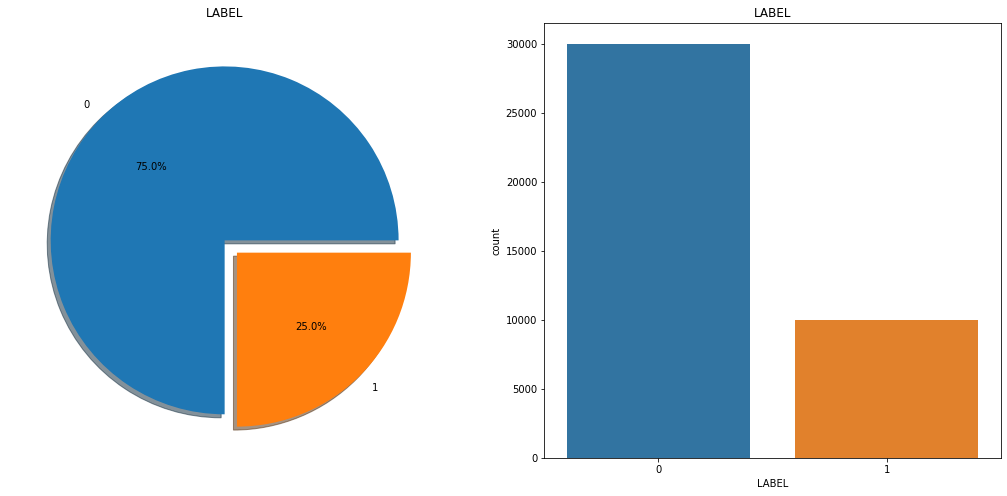

In [42]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train['LABEL'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('LABEL')
ax[0].set_ylabel('')
sns.countplot('LABEL',data=train,ax=ax[1])
ax[1].set_title('LABEL')
plt.show()

In [26]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {testa.shape[0]} rows and {testa.shape[1]} columns.')
print(f'Test dataset has {testb.shape[0]} rows and {testb.shape[1]} columns.')

Train dataset has 40000 rows and 51 columns.
Test dataset has 12000 rows and 50 columns.
Test dataset has 12000 rows and 50 columns.


In [27]:
print(f'There are {train.isnull().any().sum()} columns in train dataset with missing values.')
print(f'There are {testa.isnull().any().sum()} columns in testa dataset with missing values.')
print(f'There are {testb.isnull().any().sum()} columns in testb dataset with missing values.')

There are 49 columns in train dataset with missing values.
There are 49 columns in testa dataset with missing values.
There are 49 columns in testb dataset with missing values.


In [28]:
one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_testa = [col for col in testa.columns if testa[col].nunique() <= 1]
one_value_cols_testb = [col for col in testa.columns if testa[col].nunique() <= 1]
one_value_cols == one_value_cols_testb
one_value_cols_testb

['MON_12_CUST_CNT_PTY_ID']

In [29]:
print(f'There are {len(one_value_cols)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_testa)} columns in testa dataset with one unique value.')
print(f'There are {len(one_value_cols_testb)} columns in testb dataset with one unique value.')

There are 1 columns in train dataset with one unique value.
There are 1 columns in testa dataset with one unique value.
There are 1 columns in testb dataset with one unique value.


count    3.421000000000000e+03
mean     2.547363226831336e+07
std      1.552969149231013e+08
min      9.065600000000000e+03
25%      8.366515000000000e+05
50%      2.908149900000000e+06
75%      1.123773290000000e+07
max      4.185786079000000e+09
Name: AGN_CUR_YEAR_WAG_AMT, dtype: float64

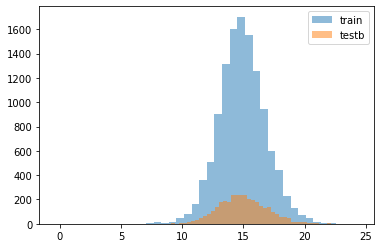

In [41]:
feature =  'AGN_CUR_YEAR_WAG_AMT' #AGN_CUR_YEAR_AMT -1.15 #'AGN_AGR_LATEST_AGN_AMT'+ 0.75 PUB_TO_PRV_TRX_AMT_CUR_YEAR -0.75
#'OPN_TM'+0.35
tmp = train[feature].apply(lambda x: np.log(x)-1.15)
tmp1 = testa[feature].apply(lambda x: np.log(x))
tmp2 = testb[feature].apply(lambda x: np.log(x))
tmp3 = valid[feature].apply(lambda x: np.log(x))
plt.hist(tmp[np.isfinite(tmp)], bins=40, label='train',alpha=0.5)
#plt.hist(tmp1[np.isfinite(tmp1)], bins=40, label='testa',alpha=0.5)
plt.hist(tmp2[np.isfinite(tmp2)], bins=40, label='testb',alpha=0.5)
#plt.hist(tmp3[np.isfinite(tmp2)], bins=40, label='valid',alpha=0.5)
plt.legend()

testb[feature].describe()

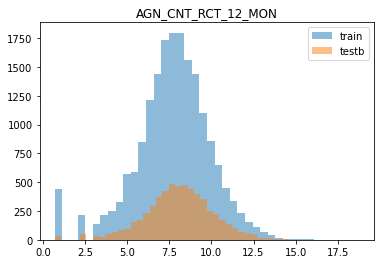

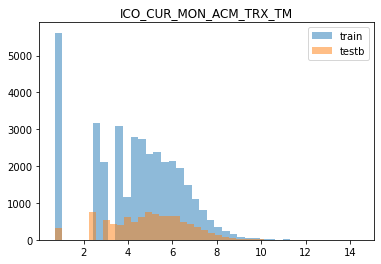

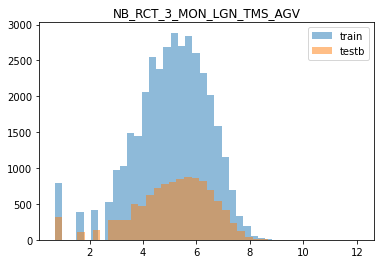

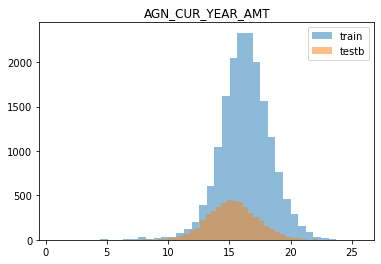

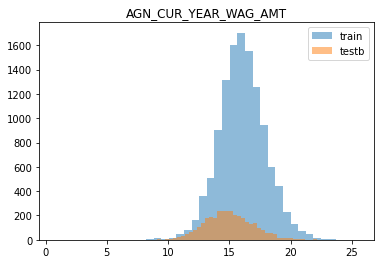

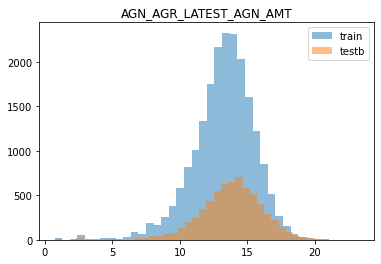

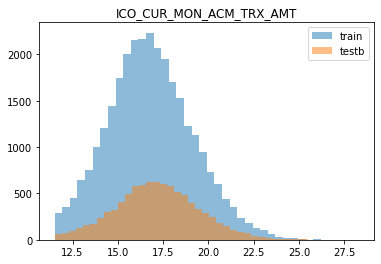

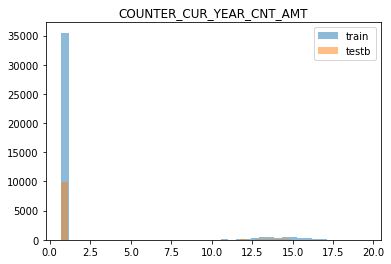

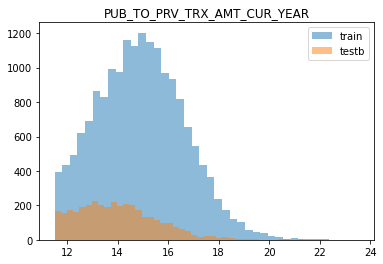

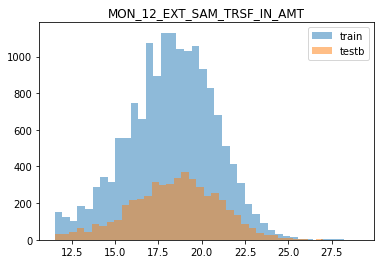

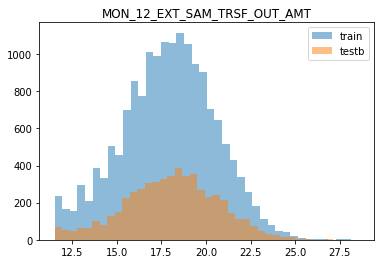

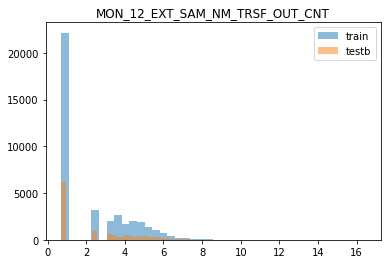

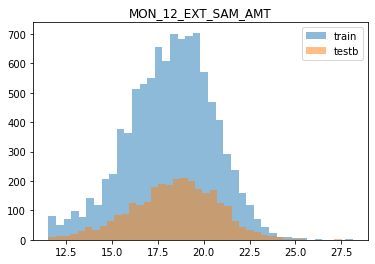

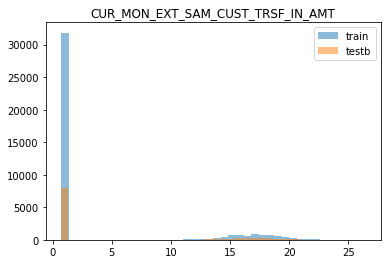

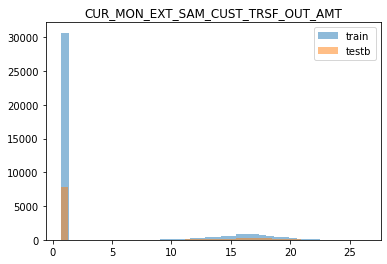

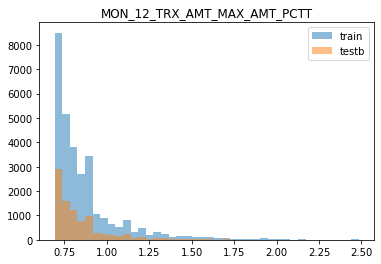

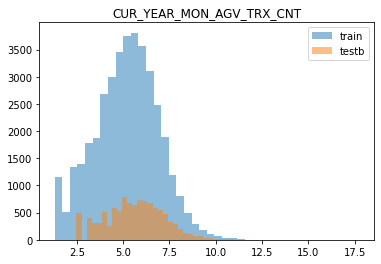

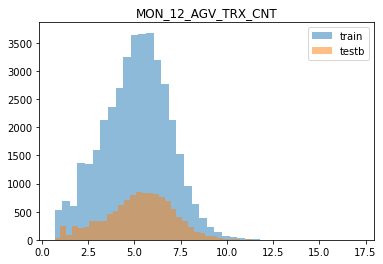

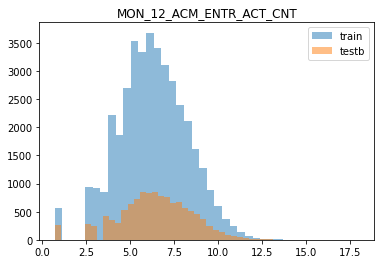

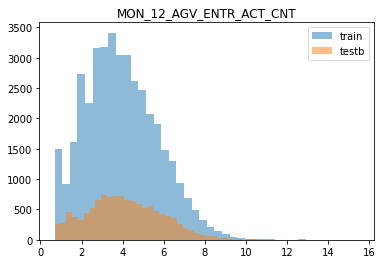

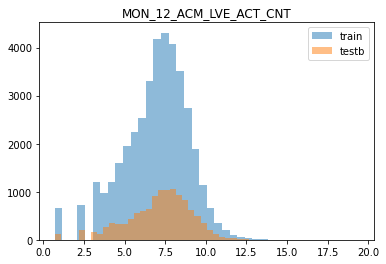

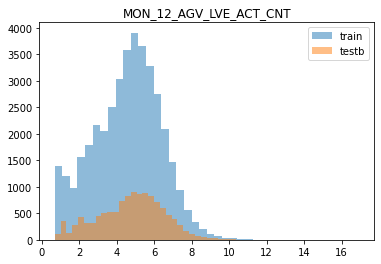

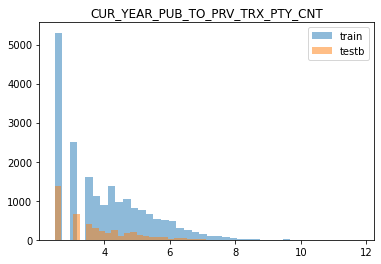

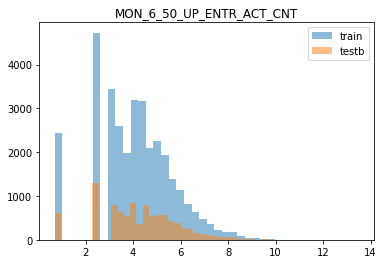

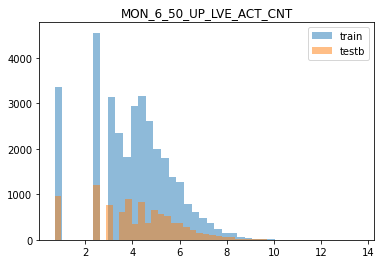

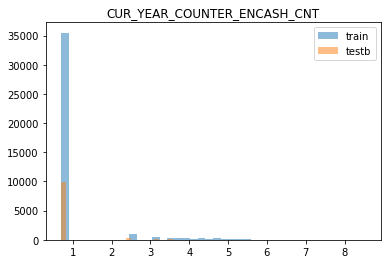

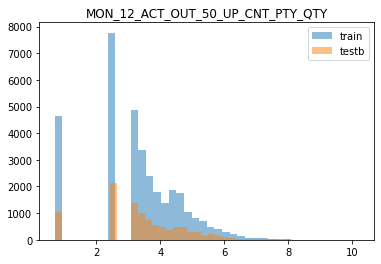

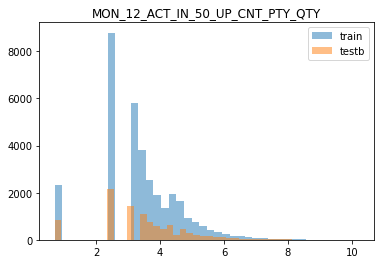

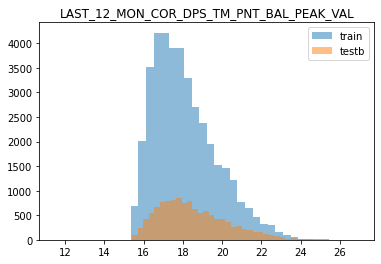

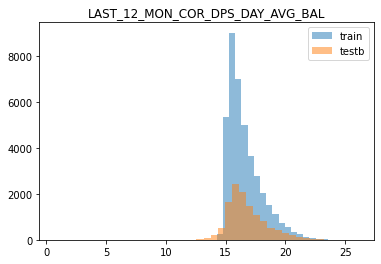

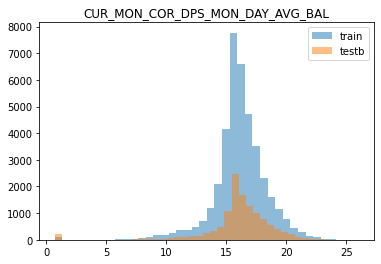

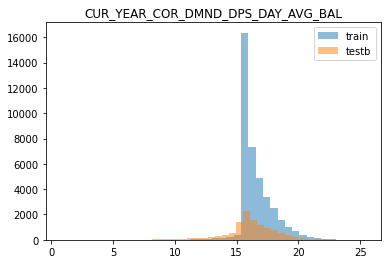

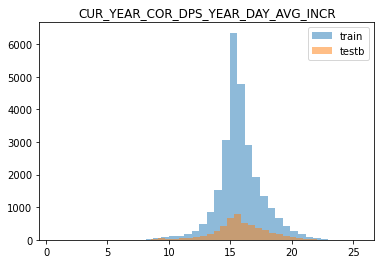

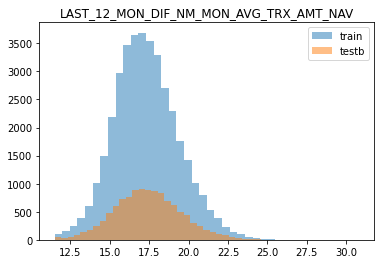

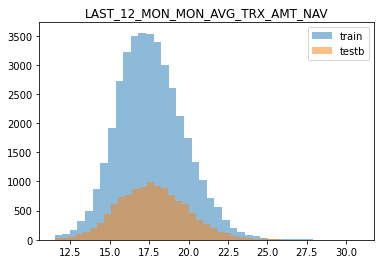

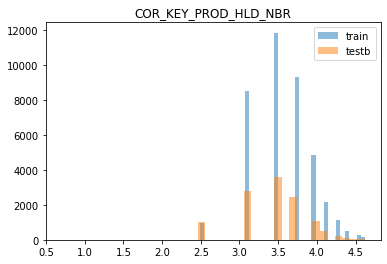

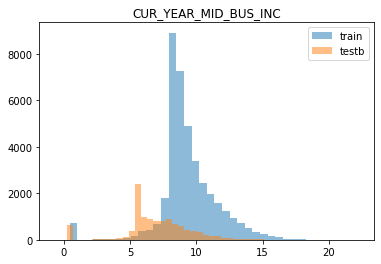

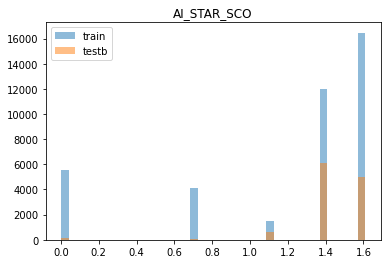

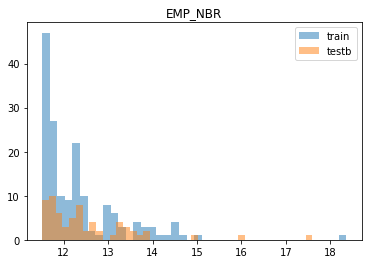

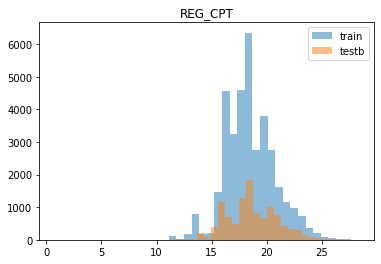

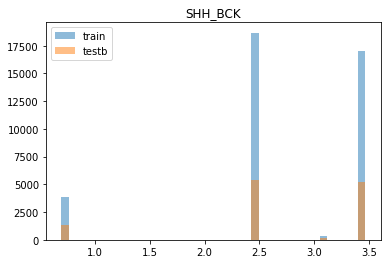

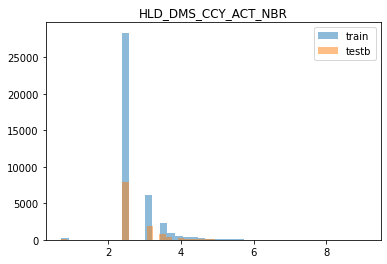

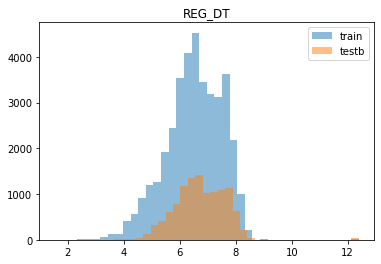

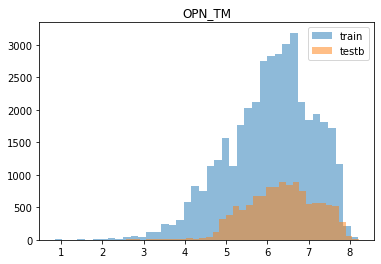

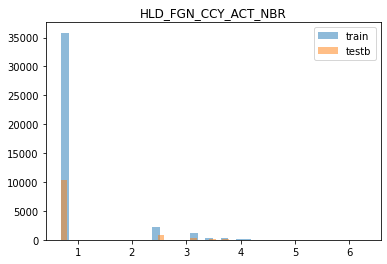

In [52]:
need_clean_cols = ['ICO_CUR_MON_ACM_TRX_AMT','PUB_TO_PRV_TRX_AMT_CUR_YEAR',
'MON_12_EXT_SAM_TRSF_IN_AMT','MON_12_EXT_SAM_TRSF_OUT_AMT',
'MON_12_EXT_SAM_AMT','LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV',
'LAST_12_MON_MON_AVG_TRX_AMT_NAV', 'EMP_NBR',
]

def clean_2_fea(train,test):
    for col in need_clean_cols:
        train[col] = train[col].apply(lambda x: None if x< 100000 else x)
        test[col] = test[col].apply(lambda x: None if x< 100000 else x)
    return train,test

train,testb = clean_2_fea(train,testb)

for feature in train.columns[2:]:
    try:
        tmp = train[feature].apply(lambda x: np.log(x))
        tmp1 = testa[feature].apply(lambda x: np.log(x))
        tmp2 = testb[feature].apply(lambda x: np.log(x))
        tmp3 = valid[feature].apply(lambda x: np.log(x))
        plt.figure()
        plt.hist(tmp[np.isfinite(tmp)], bins=40, label='train',alpha=0.5)
        #plt.hist(tmp1[np.isfinite(tmp1)], bins=40, label='testa',alpha=0.5)
        plt.hist(tmp2[np.isfinite(tmp2)], bins=40, label='testb',alpha=0.5)
        #plt.hist(tmp3[np.isfinite(tmp2)], bins=40, label='valid',alpha=0.5)
        plt.legend()
        plt.title(feature)
    except:
        pass

['MON_12_CUST_CNT_PTY_ID']

There are 0 columns in train dataset with one unique value.
There are 0 columns in test dataset with one unique value.


In [37]:
print(train.columns)

Index(['CUST_UID', 'LABEL', 'AGN_CNT_RCT_12_MON', 'ICO_CUR_MON_ACM_TRX_TM',
       'NB_RCT_3_MON_LGN_TMS_AGV', 'AGN_CUR_YEAR_AMT', 'AGN_CUR_YEAR_WAG_AMT',
       'AGN_AGR_LATEST_AGN_AMT', 'ICO_CUR_MON_ACM_TRX_AMT',
       'COUNTER_CUR_YEAR_CNT_AMT', 'PUB_TO_PRV_TRX_AMT_CUR_YEAR',
       'MON_12_EXT_SAM_TRSF_IN_AMT', 'MON_12_EXT_SAM_TRSF_OUT_AMT',
       'MON_12_EXT_SAM_NM_TRSF_OUT_CNT', 'MON_12_EXT_SAM_AMT',
       'CUR_MON_EXT_SAM_CUST_TRSF_IN_AMT', 'CUR_MON_EXT_SAM_CUST_TRSF_OUT_AMT',
       'MON_12_CUST_CNT_PTY_ID', 'MON_12_TRX_AMT_MAX_AMT_PCTT',
       'CUR_YEAR_MON_AGV_TRX_CNT', 'MON_12_AGV_TRX_CNT',
       'MON_12_ACM_ENTR_ACT_CNT', 'MON_12_AGV_ENTR_ACT_CNT',
       'MON_12_ACM_LVE_ACT_CNT', 'MON_12_AGV_LVE_ACT_CNT',
       'CUR_YEAR_PUB_TO_PRV_TRX_PTY_CNT', 'MON_6_50_UP_ENTR_ACT_CNT',
       'MON_6_50_UP_LVE_ACT_CNT', 'CUR_YEAR_COUNTER_ENCASH_CNT',
       'MON_12_ACT_OUT_50_UP_CNT_PTY_QTY', 'MON_12_ACT_IN_50_UP_CNT_PTY_QTY',
       'LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL',
    

count    1.097700000000000e+04
mean     3.353473583440102e+08
std      3.313968448962001e+09
min      2.000000000000000e+00
25%      7.118720000000000e+05
50%      9.444134199999999e+06
75%      6.127458320000000e+07
max      1.619718085795000e+11
Name: ICO_CUR_MON_ACM_TRX_AMT, dtype: float64

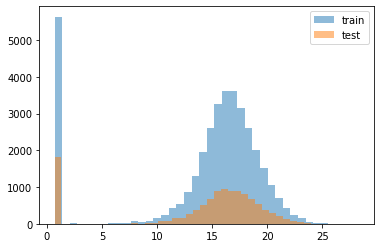

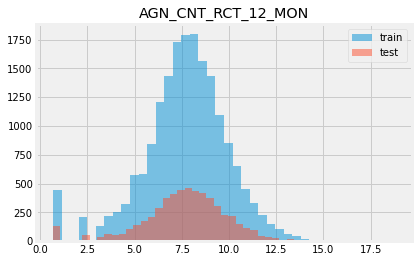

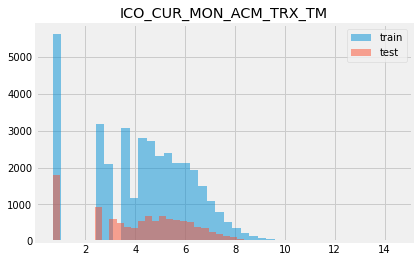

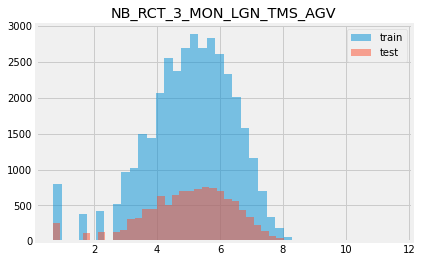

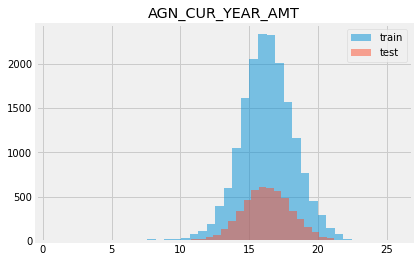

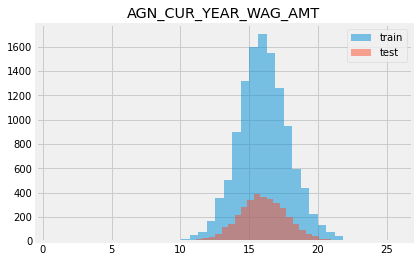

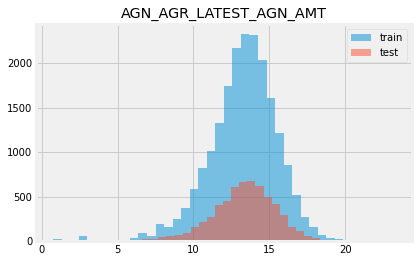

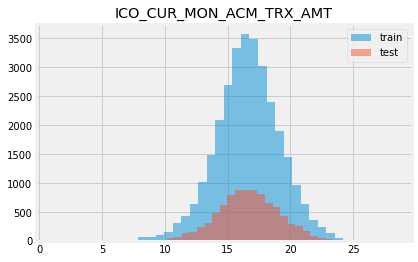

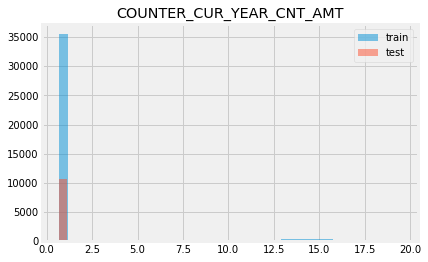

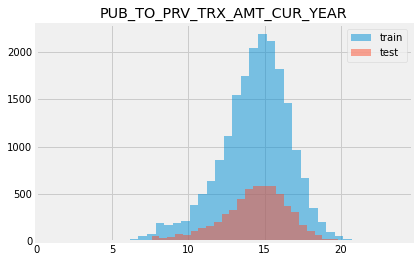

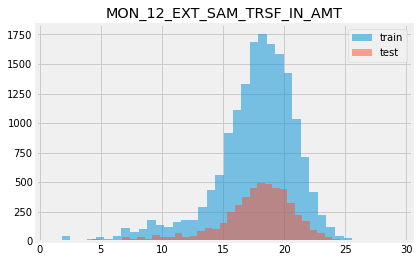

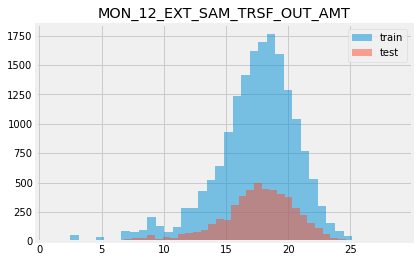

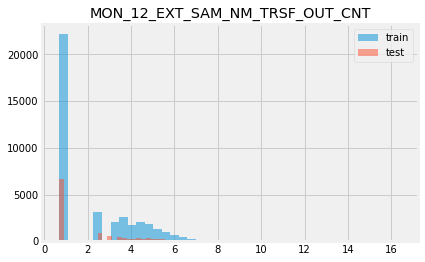

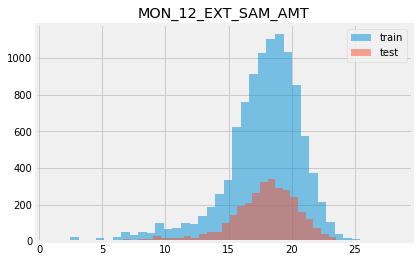

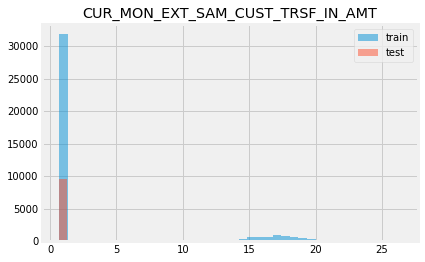

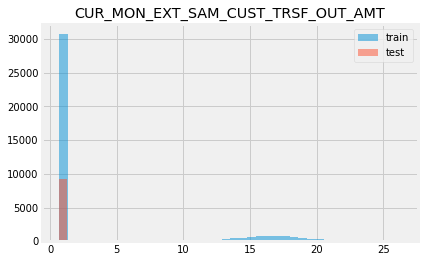

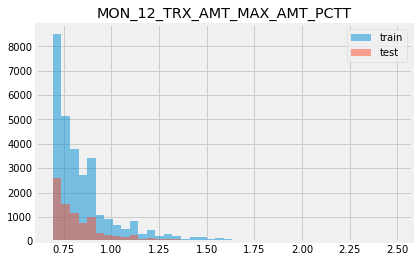

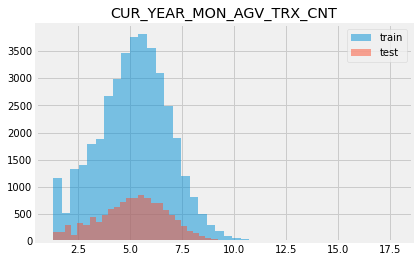

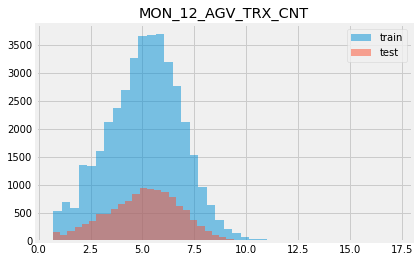

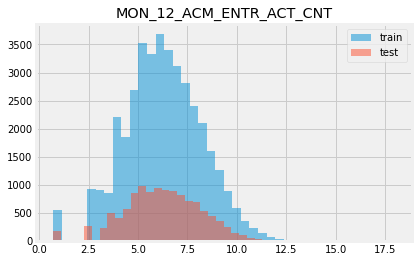

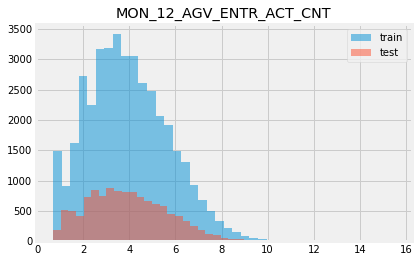

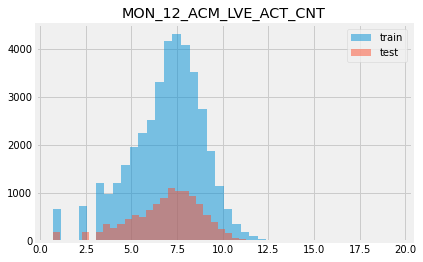

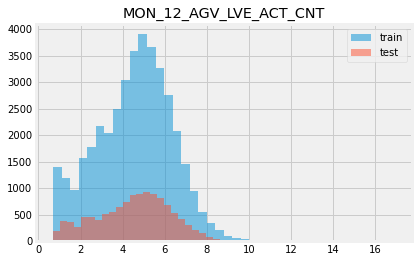

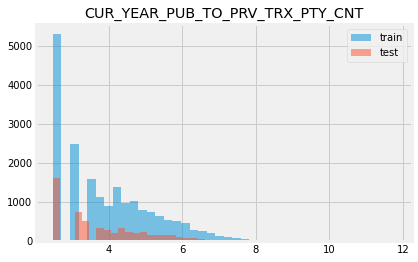

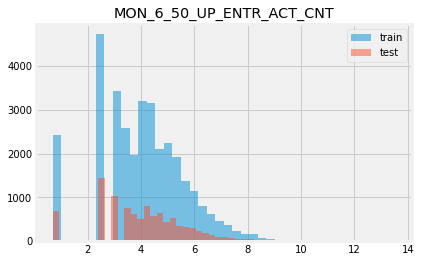

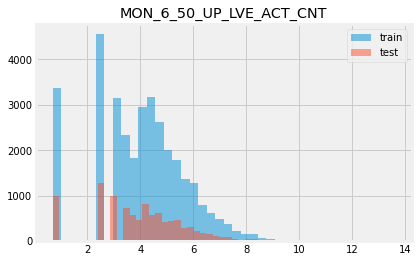

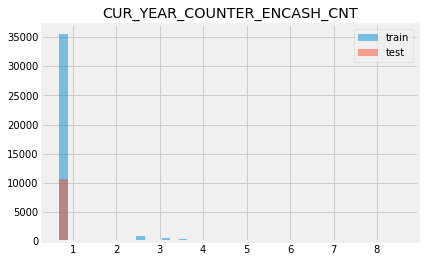

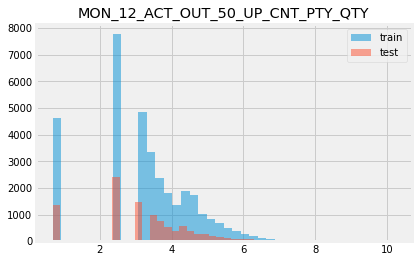

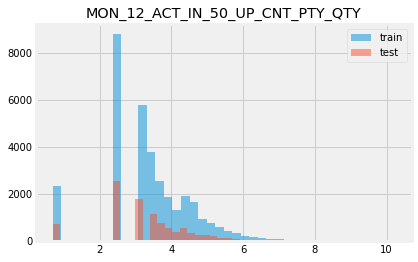

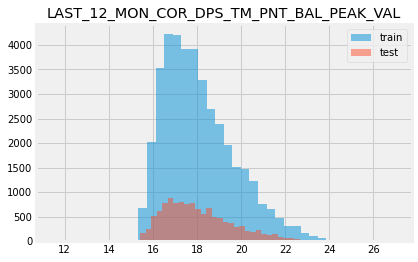

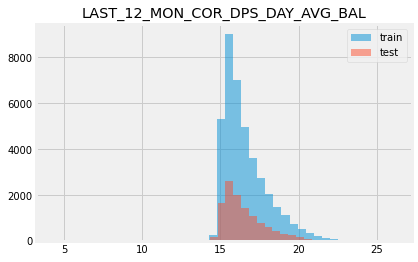

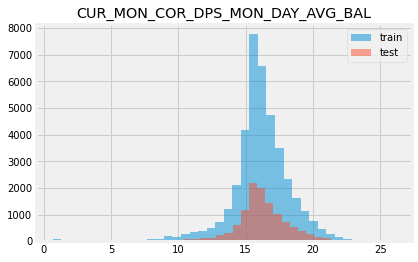

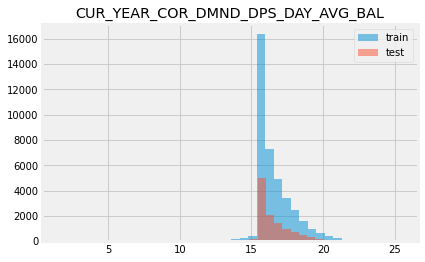

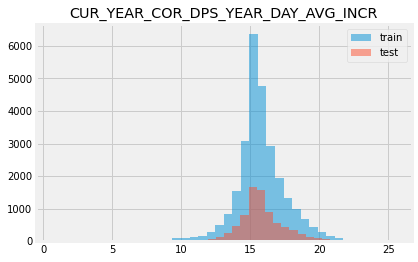

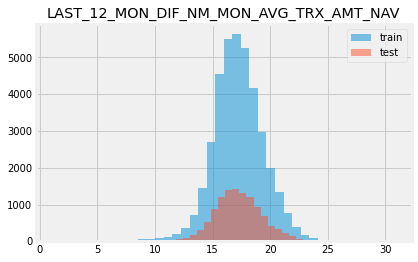

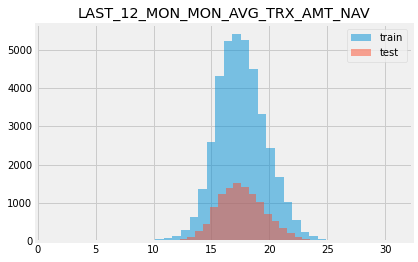

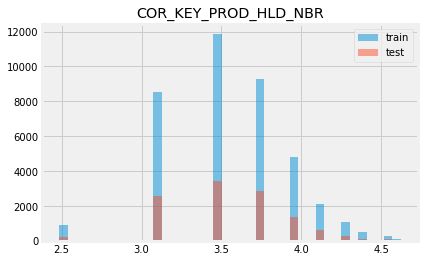

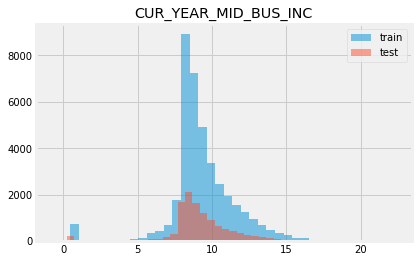

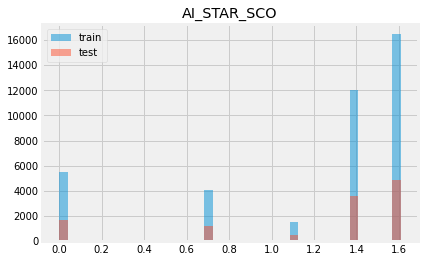

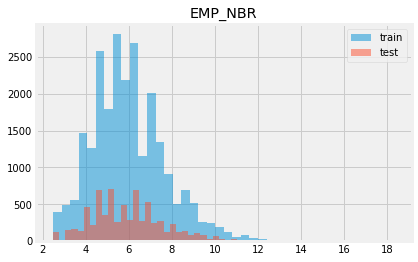

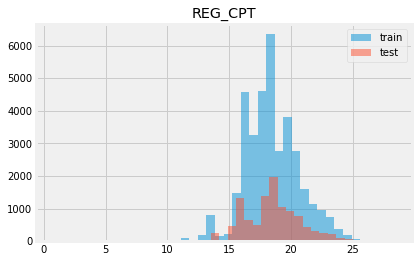

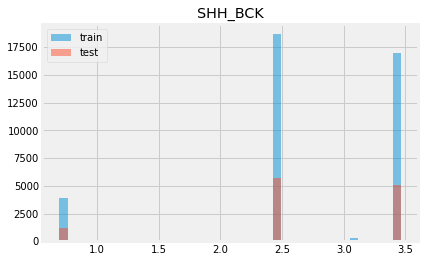

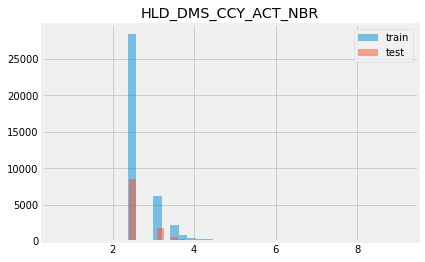

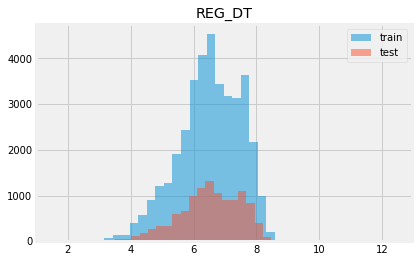

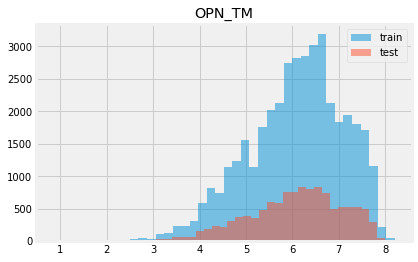

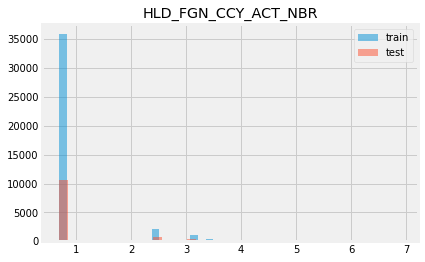

In [40]:
#需要进一步确认
[ 'AGN_CUR_YEAR_WAG_AMT', 'AGN_AGR_LATEST_AGN_AMT',
'MON_12_EXT_SAM_NM_TRSF_OUT_CNT','MON_12_EXT_SAM_AMT','MON_12_CUST_CNT_PTY_ID'
,'CUR_MON_COR_DPS_MON_DAY_AVG_BAL','CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL',
'CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR','LAST_12_MON_MON_AVG_TRX_AMT_NAV','LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV',
'EMP_NBR']

#分桶后只有一列
['ICO_CUR_MON_ACM_TRX_AMT','COUNTER_CUR_YEAR_CNT_AMT','PUB_TO_PRV_TRX_AMT_CUR_YEAR'
,'MON_12_EXT_SAM_TRSF_IN_AMT', 'MON_12_EXT_SAM_TRSF_OUT_AMT','CUR_MON_EXT_SAM_CUST_TRSF_IN_AMT'
,'CUR_MON_EXT_SAM_CUST_TRSF_OUT_AMT', 'CUR_YEAR_COUNTER_ENCASH_CNT','CUR_YEAR_MIN_BUS_INC'
,'HLD_FGN_CCY_ACT_NBR']

#没数据
['AGN_CUR_YEAR_AMT','LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL','LAST_12_MON_COR_DPS_DAY_AVG_BAL','REG_CPT']


['LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL',
 'LAST_12_MON_COR_DPS_DAY_AVG_BAL',
 'REG_CPT']

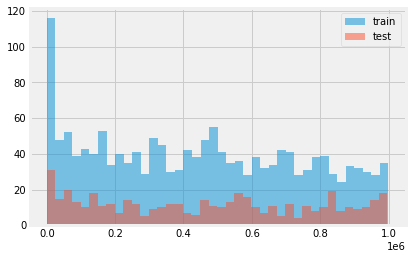

In [25]:
train['AGN_CUR_YEAR_AMT'].describe()
# 这里的2可能是溢出，感觉可以直接作为空值处理，分布差异还是蛮大的，而且数值巨大，需要归一化处理
#test['AGN_CUR_YEAR_AMT'].value_counts()
feature = 'AGN_CUR_YEAR_AMT'
tmp = train[feature][train[feature] <1000000]
tmp2 = test[feature][test[feature] <1000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()

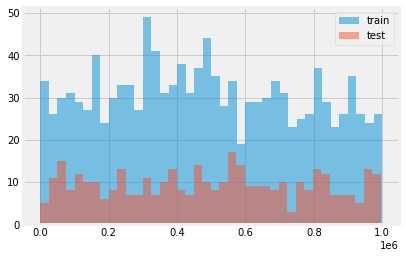

In [26]:
train['AGN_CUR_YEAR_WAG_AMT'].describe()
feature = 'AGN_CUR_YEAR_WAG_AMT'
tmp = train[feature][train[feature] <1000000]
tmp2 = test[feature][test[feature] <1000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()

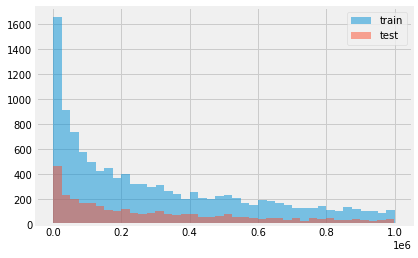

In [27]:
train['AGN_AGR_LATEST_AGN_AMT'].describe()
feature = 'AGN_AGR_LATEST_AGN_AMT'
tmp = train[feature][train[feature] <1000000]
tmp2 = test[feature][test[feature] <1000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()

count    3.340000000000000e+03
mean     9.684088134235928e+08
std      5.841768707020948e+09
min      3.000000200000000e+07
25%      5.771243717500000e+07
50%      1.310697472500000e+08
75%      4.143185395250000e+08
max      1.619718085795000e+11
Name: ICO_CUR_MON_ACM_TRX_AMT, dtype: float64

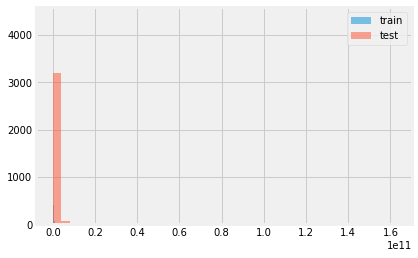

In [46]:
train['ICO_CUR_MON_ACM_TRX_AMT'].describe()
feature = 'ICO_CUR_MON_ACM_TRX_AMT'
tmp = train[feature][train[feature] >30000000 ][train[feature] < 2000000000]
tmp2 = test[feature][test[feature] >30000000][train[feature] < 2000000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
tmp2.describe()

count    2.860000000000000e+02
mean     7.358656159440559e+06
std      3.977205551659274e+06
min      3.000002000000000e+06
25%      4.370002000000000e+06
50%      6.000002000000000e+06
75%      9.620002000000000e+06
max      1.984554410000000e+07
Name: COUNTER_CUR_YEAR_CNT_AMT, dtype: float64

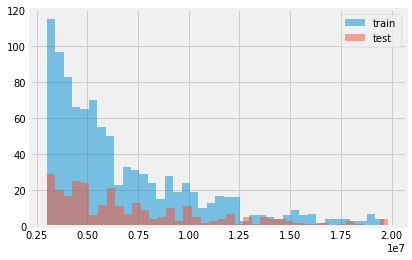

In [51]:
train['COUNTER_CUR_YEAR_CNT_AMT'].describe()
feature = 'COUNTER_CUR_YEAR_CNT_AMT'
tmp = train[feature][train[feature] >3000000][train[feature] < 20000000]
tmp2 = test[feature][test[feature] >3000000][test[feature] < 20000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
tmp2.describe()

count    1.861000000000000e+03
mean     8.164763261526061e+06
std      4.491516516477012e+06
min      3.000002000000000e+06
25%      4.516124000000000e+06
50%      6.733657200000000e+06
75%      1.078104800000000e+07
max      1.998119190000000e+07
Name: PUB_TO_PRV_TRX_AMT_CUR_YEAR, dtype: float64

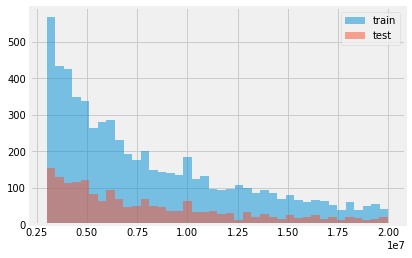

In [52]:

train['PUB_TO_PRV_TRX_AMT_CUR_YEAR'].describe()
feature = 'PUB_TO_PRV_TRX_AMT_CUR_YEAR'
tmp = train[feature][train[feature] >3000000][train[feature] < 20000000]
tmp2 = test[feature][test[feature] >3000000][test[feature] < 20000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
tmp2.describe()


count    7.970000000000000e+02
mean     9.735708720577164e+06
std      4.766671565071108e+06
min      3.000002000000000e+06
25%      5.415165300000000e+06
50%      9.141760500000000e+06
75%      1.400000200000000e+07
max      1.999000200000000e+07
Name: MON_12_EXT_SAM_TRSF_IN_AMT, dtype: float64

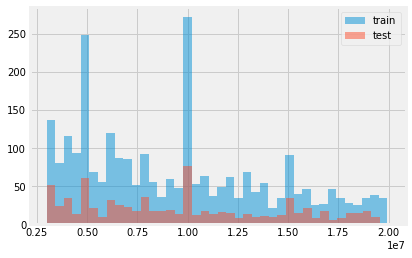

In [53]:
train['MON_12_EXT_SAM_TRSF_IN_AMT'].describe()
feature = 'MON_12_EXT_SAM_TRSF_IN_AMT'
tmp = train[feature][train[feature] >3000000][train[feature] < 20000000]
tmp2 = test[feature][test[feature] >3000000][test[feature] < 20000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
tmp2.describe()

count    9.470000000000000e+02
mean     9.827965342661034e+06
std      4.725068288187432e+06
min      3.000002000000000e+06
25%      5.613494000000000e+06
50%      9.600002000000000e+06
75%      1.350371050000000e+07
max      1.999950200000000e+07
Name: MON_12_EXT_SAM_TRSF_OUT_AMT, dtype: float64

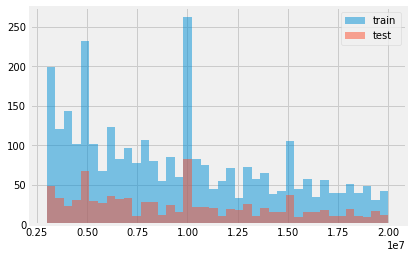

In [54]:

feature = 'MON_12_EXT_SAM_TRSF_OUT_AMT'
tmp = train[feature][train[feature] >3000000][train[feature] < 20000000]
tmp2 = test[feature][test[feature] >3000000][test[feature] < 20000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
tmp2.describe()


2.000000200000000e+07    40
1.000000200000000e+07    24
1.500000200000000e+07    11
2.999930200000000e+07     5
1.999930200000000e+07     5
                         ..
1.335557640000000e+07     1
6.248317800000000e+06     1
1.931166750000000e+07     1
5.267808300000000e+06     1
1.077069990000000e+07     1
Name: LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL, Length: 13724, dtype: int64

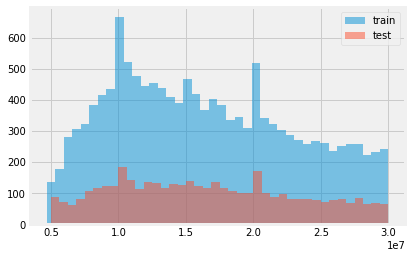

In [18]:
feature = 'LAST_12_MON_COR_DPS_TM_PNT_BAL_PEAK_VAL'
tmp = train[feature][train[feature] >3000000][train[feature] < 30000000]
tmp2 = test[feature][test[feature] >3000000][test[feature] < 30000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
tmp.value_counts()
#tmp2.value_counts()

5.000002000000000e+06    30
5.524863900000000e+06     6
5.086016200000000e+06     3
7.182506600000000e+06     2
1.657458760000000e+07     2
                         ..
5.337341100000000e+06     1
5.569640200000000e+06     1
1.646861480000000e+07     1
1.034815740000000e+07     1
2.102510425000000e+08     1
Name: CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL, Length: 39739, dtype: int64

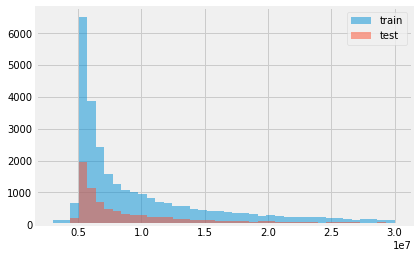

In [21]:
feature = 'CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL'

tmp = train[feature][train[feature] >3000000][train[feature] < 30000000]#5000000000
tmp2 = test[feature][test[feature] >3000000][test[feature] < 30000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
train[feature].value_counts()

5.524863900000000e+06    6
2.000000000000000e+00    4
4.195488000000000e+05    3
1.657458760000000e+07    2
5.340074200000000e+06    2
                        ..
1.045780000000000e+06    1
6.192926400000000e+06    1
4.864892700000000e+06    1
1.004697000000000e+06    1
8.671145120000000e+07    1
Name: CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR, Length: 39872, dtype: int64

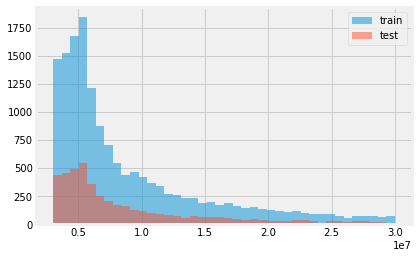

In [24]:
feature = 'CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR'
tmp = train[feature][train[feature] >3000000][train[feature] < 30000000]#5000000000
tmp2 = test[feature][test[feature] >3000000][test[feature] < 30000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
train[feature].value_counts()

2.000000000000000e+00    839
8.333335300000000e+06     35
1.666668700000000e+06     34
1.666666870000000e+07     23
8.333333530000000e+07     20
                        ... 
1.103201402900000e+09      1
2.742643200000000e+07      1
1.519584813000000e+08      1
8.540320109999999e+07      1
5.799887520000000e+07      1
Name: LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV, Length: 38338, dtype: int64

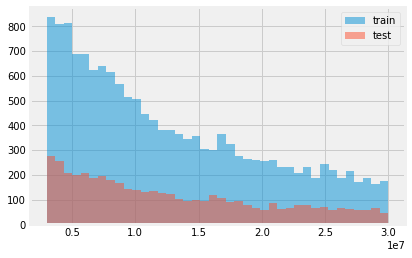

In [25]:
feature = 'LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV'
tmp = train[feature][train[feature] >3000000][train[feature] < 30000000]#5000000000
tmp2 = test[feature][test[feature] >3000000][test[feature] < 30000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
train[feature].value_counts()


2.000000000000000e+00    184
1.666668700000000e+06     27
8.333353000000000e+05     26
1.666666870000000e+07     23
8.333335300000000e+06     19
                        ... 
1.100742577000000e+08      1
4.631314700000000e+06      1
4.875774400000000e+06      1
8.792740699999999e+06      1
1.395231325000000e+08      1
Name: LAST_12_MON_MON_AVG_TRX_AMT_NAV, Length: 39106, dtype: int64

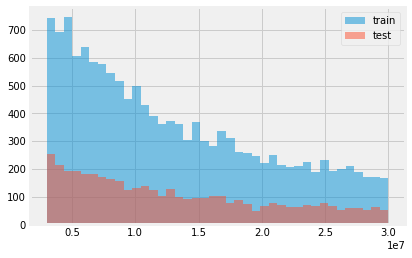

In [26]:

feature = 'LAST_12_MON_MON_AVG_TRX_AMT_NAV'
tmp = train[feature][train[feature] >3000000][train[feature] < 30000000]#5000000000
tmp2 = test[feature][test[feature] >3000000][test[feature] < 30000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
train[feature].value_counts()


2.000000000000000         737
2832.199999999999818      515
473.699999999999989        66
2827.099999999999909       43
2360.500000000000000       41
                         ... 
17065.000000000000000       1
74329.800000000002910       1
3326.199999999999818        1
10114.899999999999636       1
224234.500000000000000      1
Name: CUR_YEAR_MID_BUS_INC, Length: 34948, dtype: int64

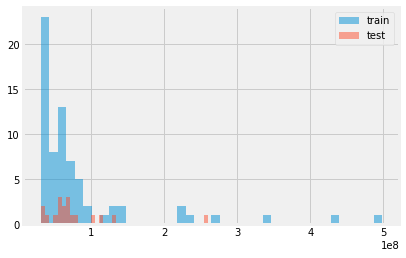

In [29]:

feature = 'CUR_YEAR_MID_BUS_INC'
tmp = train[feature][train[feature] >30000000][train[feature] < 500000000]#5000000000
tmp2 = test[feature][test[feature] >30000000][test[feature] < 500000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
train[feature].value_counts()



100000002.0     4737
10000002.0      3860
50000002.0      3455
500000002.0     1578
20000002.0      1545
                ... 
3979035392.0       1
32650002.0         1
87217552.0         1
400010002.0        1
1007800002.0       1
Name: REG_CPT, Length: 6060, dtype: int64

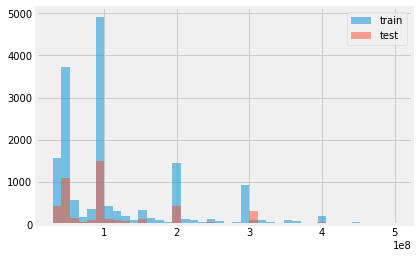

In [30]:

feature = 'REG_CPT'
tmp = train[feature][train[feature] >30000000][train[feature] < 500000000]#5000000000
tmp2 = test[feature][test[feature] >30000000][test[feature] < 500000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
train[feature].value_counts()


32.0     11847
42.0      9287
22.0      8534
52.0      4836
62.0      2155
72.0      1122
12.0       935
82.0       514
92.0       301
102.0      133
Name: COR_KEY_PROD_HLD_NBR, dtype: int64

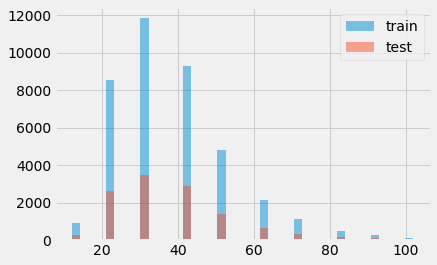

In [6]:
train['COR_KEY_PROD_HLD_NBR'].describe()
feature = 'COR_KEY_PROD_HLD_NBR'
tmp = train[feature]#[train[feature] >3000000][train[feature] < 20000000]
tmp2 = test[feature]#[test[feature] >3000000][test[feature] < 20000000]
plt.hist(tmp, bins=40, label='train',alpha=0.5)
plt.hist(tmp2, bins=40, label='test',alpha=0.5)
plt.legend()
tmp.value_counts()

In [12]:
cols = ['CUR_MON_COR_DPS_MON_DAY_AVG_BAL', 'CUR_YEAR_COR_DMND_DPS_DAY_AVG_BAL',
       'REG_DT', 'CUR_YEAR_COR_DPS_YEAR_DAY_AVG_INCR', 'REG_CPT',
       'NB_RCT_3_MON_LGN_TMS_AGV', 'LAST_12_MON_COR_DPS_DAY_AVG_BAL',
       'CUR_YEAR_MID_BUS_INC', 'ICO_CUR_MON_ACM_TRX_AMT', 'OPN_TM',
       'CUR_YEAR_MON_AGV_TRX_CNT', 'LAST_12_MON_DIF_NM_MON_AVG_TRX_AMT_NAV']
# for feature in cols:
#     tmp = train[feature]#[train[feature] <50000]
#     tmp2 = test[feature]#[test[feature] <50000]
#     plt.figure()
#     plt.hist(tmp, bins=40, label='train',alpha=0.5)
#     plt.hist(tmp2, bins=40, label='test',alpha=0.5)
#     plt.legend()
#     plt.title(feature)


40000